In [1]:
import jax
import sys
import pandas as pd
import numpy as np
import jax.numpy as jnp

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!cd "/content/drive/MyDrive/Brain Age Prediction"
sys.path.insert(0, "/content/drive/MyDrive/Brain Age Prediction")

Mounted at /content/drive


# LINEAR REGRESSION FOR BRAIN AGE PREDICTION

We have a dataset composed of $652$ samples. Each sample refers to the brain of a different person. Human brain consists of $3$ different soft-tissues: 

- Gray Matter
- White Matter
- Cerebrospinal Fluid


By using MRI scans, the volume of these $3$ tissues are measured in terms of $cm^3$ for all people in this dataset, and these volumetric measurements, ***as the features***, are recorded in a txt file. Our purpose is to predict biological age of the people by looking at tissue volumes of human brain. So, age information is added into the dataset as ground-truth label. 

In [3]:
data_dir = "/content/drive/MyDrive/Brain Age Prediction/brain_data.txt"
pd.read_csv(data_dir, sep="\t", header=0)

,GM Vol,WM Vol,CSF Vol,Total Vol,Age
0,716.280,425.440,493.752,1635.472,24
1,758.296,425.112,311.584,1494.992,18
2,788.768,396.584,281.400,1466.752,24
3,697.024,395.040,262.224,1354.288,22
4,905.728,481.752,264.872,1652.352,20
...,...,...,...,...,...
647,628.856,439.896,655.992,1724.744,79
648,540.848,360.952,720.304,1622.104,79
649,493.720,392.912,766.536,1653.168,84
650,523.032,456.640,774.816,1754.488,80


# Data Loading

First of all, we read text file to load the dataset by using standard NumPy library. In data-loading process, we carry out 3 sub-operations:

1. Divide data into features and labels
2. Scale features and labels 
3. Split data into train and test parts

The function *load_dataset(.)* is coded to encapsulate and realize these 3 data-preprocessing operations. 

In [4]:
def load_dataset(data_dir, key, split_ratio=0.9):

  dataset = np.loadtxt(data_dir, delimiter="\t", skiprows=1) # loading dataset
  data_x, data_y = dataset[:, 0:4], dataset[:, 4] # dividing into features and labels 
  data_x, data_y = scale_dataset(data_x, data_y) # feature and label scaling
  train_x, train_y, test_x, test_y = random_split(data_x, data_y, split_ratio, key) # train-test split
  
  return train_x, train_y, test_x, test_y

## Data Scaling

In linear regression, the features of each data sample are multiplied by their corresponding weights, as illustrated in the formulation below. 

$y = f_{w, b}(x) = x^T \cdot w + b$

This multiplication plus equals to model predictions. When there is a huge difference between the value scale of features and labels, gradient-based optimization becomes harder and convergence to global minima gets more difficult. That is why feature scaling is very important:

1. Features between themselves have to be in same value scale

Feature 1  | Feature 2
-----------|------------------
4.5       | 267.7 
2.3       | 432.1


In first case, feature 1 and feature 2 are not in the same value scale. In this case, one feature can seem more important than other one to the model. This has to be prevented, all features have to be in same importance rate.

2. Features and labels have to be in similar value scale. 

Feature 1   | Feature 2 | Label
------------|-----------|------
421.5       | 267.7 | 2.1
256.3       | 432.1 | 4.2

In second case, features are in same value scale, but label is quite small compared to the features. This makes optimization and convergence to global minima more difficult. 

### Non-Uniform Brain Size Problem:

For our dataset, we only need to pay attention to case 2 because volumes of brain tissues are quite bigger than biological ages. Apart from it, we also has the problem of non-uniform features. In this problem, the volume of soft-tissues changes depending on brain size. 

* *Patients with bigger brains* $\rightarrow$  *larger soft-tissues*
* *Patients with smaller brains* $\rightarrow$  *narrow soft-tissues*

In general, old people have narrow soft tissues. However, with this problem, young people with smaller brains can also have narrow tissues. This creates a contradiction and our learning model has difficulty to fit the data. 

That is why, we divide the features (volumes of 3 soft-tissues) by total volume of brain. In that way, we eliminate the effect of brain size. At the same time, we decrease value scale of features.

As a personal choice, the label for this data can be also scalable. 

In [5]:
def scale_dataset(data_x, data_y):

  # dividing the volumes of brain tissues by total brain volume
  data_x[:, 0] = np.round(data_x[:, 0] / data_x[:, 3], 3)
  data_x[:, 1] = np.round(data_x[:, 1] / data_x[:, 3], 3)
  data_x[:, 2] = np.round(data_x[:, 2] / data_x[:, 3], 3)
  data_y = np.round(data_y / 100., 2)

  return jnp.array(data_x[:, :3]), jnp.array(data_y)

## Train-Test Split

* Model optimization by gradient descent $\rightarrow$ training stage
* Checking model performance after the optimization $\rightarrow$ testing stage

We cannot test the model on training dataset; the result would be misleading. We need to have a different dataset for testing. That is why we split entire dataset randomly into *training* and *testing* subsets by $90:10$ percentage.

In [6]:
def random_split(data_x, data_y, ratio, key):

  num_samples = data_x.shape[0]
  num_train_samples = round(num_samples * ratio)

  data_x = jax.random.permutation(key, data_x, axis=0)
  data_y = jax.random.permutation(key, data_y, axis=0)

  train_x, train_y = data_x[:num_train_samples], data_y[:num_train_samples]
  test_x, test_y = data_x[num_train_samples:], data_y[num_train_samples:]
  return train_x, train_y, test_x, test_y

# Development of Linear Regression Model

## 1. Initializer

First of all, we need to have an initializer function that will generate random values for the model parameters *weights* $W$ and *bias* $b$. For this purpose, we use the function $init(.)$. It takes $3$ input arguments:

* PRNG (Pseudo Random Number Generator) Key
* Weight Shape
* Bias Shape

In JAX, we choose a seed value to define a randomization key. This key is used to generate random values. Random values that you generate rely on key itself. If you use same key, you always generate same random values. 

The shape of weight is related to how many features we will use. In our coding session, we train and optimize our linear model with 1-feature (gray matter) and 3-features versions of same dataset. Hence, the shape of the weight vector will be a vertical vector of $(1,)$ and $(3,)$. On the other hand, the shape of bias is fixed, which will be one scalar value.

In [7]:
def init(key, weight_shape, bias_shape):

  """
  * It takes a PRNG key value as input, and uses it to generate random weights 
    and bias for the model.
  * Randomly generated weights and bias are gathered in a small pytree to be 
    returned by the function.

  Parameters:
  -----------
  - key: It is generated by jax.PRNGKey(seed) and passed to this function
  - weight_shape: a tuple to specify the number of weights in shape form (3,)
  - bias_shape: a tuple to specify the number of biases in shape form (1,)
  """

  weights_key, bias_key = jax.random.split(key)
  weights = jax.random.normal(weights_key, weight_shape)
  bias = jax.random.normal(bias_key, bias_shape)
  param_tree = {"weights": weights, "bias": bias}

  return param_tree

## 2. Model and Loss Functions

We will use a linear regressor to fit the data, so our model formulation will be the mathematical function given below:

$\hat{y} = f_{w, b}(x) = x^T \cdot w + b$

For this formulation, we use $jax.numpy$. Numpy library in JAX is imported as $jnp$. We apply dot product between feature vector and weight vector. Then, we sum the result of dot product with bias term, which results in model predictions. In mathematical formulation, model function only receives data sample as input, but in coding perspective, we also pass its parameters as input argument.

As a loss function, we will use $MSE$ loss due to regression task.

$\mathcal{L}(w, b) = \frac{1}{N}\sum_{i = 1}^{N}(f_{w, b}(x^i) - y^i)^2$

For the definition of loss function, we will again use $jax.numpy$. The predictions are already made by model function, and we have their corresponding ground-truth labels. We pass them into our loss function as input arguments. First of all, it computes the difference between the predictions and the labels. Then, it takes the square of them and computes their average loss.

In [8]:
def model(params, xs):

  """
  * Linear regression model
  * It receives parameters and data samples as input.
  * Features of data samples are multiplied by weights and summed up with bias.

  Parameters:
  -----------
  - params: a pytree containing weights and bias of the model
  - xs: data features in the shape of (N, 3)
  """

  preds = jnp.dot(xs, params["weights"]) + params["bias"]
  return preds


def loss_fn(preds, labels):
  # MSE (mean squared error loss)
  return jnp.mean(jnp.square(preds - labels))

## Forward Function

We actually defined model function and loss function separately. Function $forward(.)$ combines both in one place. By using model function, it will make predictions. Then, by using predictions and ground-truth labels, it computes total error. 

The main reason why we need to combine them is gradient computation. We need to compute the gradient vector of loss function $\nabla \mathcal{L}$ with respect to the parameters $(W, b)$. Model parameters are not in loss function; they are located in model function. In this case, we cannot differentiate them. That is why we combined these functions in one place. 

We just-in-time compile $forward(.)$ function because its input shape is fixed for each iteration of optimization process. This provides additional acceleration in forward pass of the model.

In [9]:
@jax.jit
def forward(params, xs, ys):

  """
  * It combines model and loss functions to represent one forward pass.
  * Gradient computation (backpropagation) is performed over "forward" function 
    to differentiate from loss to all parameters.

  Parameters:
  -----------
  - params: the pytree containing weights and bias of the model
  - xs: features of data samples in the shape of (N, 2)
  - ys: labels of data samples in the shape of (N, )
  """

  preds = model(params, xs)
  loss = loss_fn(preds, ys)
  return loss, preds

## Gradient Descent Algorithm

The function $grad\_descent$ represents one iteration of our gradient descent algorithm. Execution behavior of this function is split into $3$ steps:

1. We pass our function $forward(.)$ to composable function transformation $jax.value\_and\_grad(.)$. It differentiates forward function and returns its derivative as a new function called $grad\_fn(.)$. $grad\_fn(.)$ can perform both forward and backward passes at the same time. 
* In forward pass, it returns loss value $L$ and model predictions $\hat{y}$.
* In backward pass, it returns gradient of loss value with respect to $w$ and $b$.

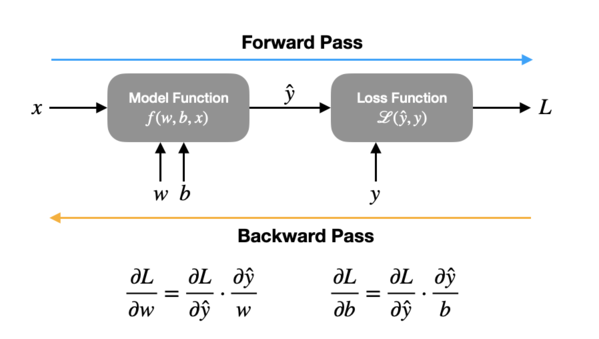


2. Parameter update is defined with a lambda function called $update(.)$. 

3. The function $update(.)$ is applied to the parameters by using $jax.tree\_map(.)$. 

Why do we use $jax.value\_and\_grad(.)$ instead of using $jax.grad(.)$ ? Because, to be able to compute the performance of the model predictions in $R^2$ score, we need to store model predictions. Besides, to keep track of loss values in each iteration, we need to have explicitly stored loss values. If we just use $jax.grad(.)$, we do not have predictions and loss values generated by forward pass. 


In [10]:
LR = 0.05

def grad_descent(params, xs, ys):

  """
  * It applies stochastic gradient descent on model parameters in each iteration.
  * The content of arguments passed to the function "update" changes, but their
    shape and type remain same. Hence, jit-compiling the function "update" by
    ShapedArray abstraction level is possible and makes sense for efficiency.
  
  Parameters:
  -----------

  - params: a pytree containing weights and bias of the model
  - xs: features of data samples in the shape of (N, 2)
  - ys: labels of data samples in the shape of (N, )

  """

  # Forward and backward passes
  # Computing loss and its relevant gradients
  grad_fn = jax.value_and_grad(forward, has_aux=True)
  (loss, preds), grad = grad_fn(params, xs, ys)
  r2 = r2_score(preds, ys)

  # Update in gradient descent algorithm W := W - lr * ∂W
  update = lambda param, grads: param - LR * grads

  # Each parameter in the pytree "params" is updated by using gradient descent.
  # To be able to do this update, computed gradients are used.
  new_params = jax.tree_map(update, params, grad)

  return new_params, loss, r2

## $R^2$ Score

It is a metric to evaluate predictive capability of regression models. It varies in the range of $(0, 1)$. Perfect models achieves $R^2 = 1$ value. If you have a negative $R^2$, then there should be something wrong with your model or loss definition. The formula of $R^2$ measurement is given below:

$R^2 = 1 - \frac{\sum_{i=1}^N (y^i - \hat{y}^i)^2}{\sum_{i=1}^N (y^i - y_m)^2}, \,\,\,\, y_m = \frac{1}{N} \sum_{i=1}^N y^i$

In [11]:
def r2_score(preds, ys):

  mean_ys = jnp.mean(ys)

  num = jnp.sum(jnp.square(ys - preds))
  denom = jnp.sum(jnp.square(ys - mean_ys))
  return 1 - (num / denom)

In [12]:
# TRAIN WITH ONE FEATURE: Gray Matter

seed = 13
weight_shape, bias_shape = (1,), (1,)

# generating randomization keys
# key1 for train-test split
# key2 for weight-bias initialization
key = jax.random.PRNGKey(seed)
key1, key2 = jax.random.split(key)

# data loading and choosing only gray matter as feature
train_x, train_y, test_x, test_y = load_dataset(data_dir, key1, split_ratio=0.9)
train_x, test_x = jnp.expand_dims(train_x[:, 0], axis=1), jnp.expand_dims(test_x[:, 0], axis=1)


params = init(key2, (1,), (1,))


print("TRAINING: ")
print("----------")
for i in range(15000):
  params, loss, r2 = grad_descent(params, train_x, train_y)
  if i % 50 == 0:
    print(f"Iteration {i}. Loss: {loss}, R2 Score: {r2}")

TRAINING: 
----------
Iteration 0. Loss: 0.2972550690174103, R2 Score: -7.638233184814453
Iteration 50. Loss: 0.02365133911371231, R2 Score: 0.31269198656082153
Iteration 100. Loss: 0.023276790976524353, R2 Score: 0.32357633113861084
Iteration 150. Loss: 0.02291281893849373, R2 Score: 0.334153413772583
Iteration 200. Loss: 0.022558214142918587, R2 Score: 0.3444581627845764
Iteration 250. Loss: 0.022212736308574677, R2 Score: 0.3544977903366089
Iteration 300. Loss: 0.02187614142894745, R2 Score: 0.36427927017211914
Iteration 350. Loss: 0.021548207849264145, R2 Score: 0.3738090395927429
Iteration 400. Loss: 0.021228712052106857, R2 Score: 0.38309353590011597
Iteration 450. Loss: 0.020917437970638275, R2 Score: 0.39213913679122925
Iteration 500. Loss: 0.020614171400666237, R2 Score: 0.4009521007537842
Iteration 550. Loss: 0.020318713039159775, R2 Score: 0.4095380902290344
Iteration 600. Loss: 0.020030852407217026, R2 Score: 0.4179033637046814
Iteration 650. Loss: 0.019750403240323067, R2 

In [13]:
print("\nTESTING: ")
print("---------")
test_preds = model(params, test_x)
r2 = r2_score(test_preds, test_y)
loss = loss_fn(test_preds, test_y)
print("Test r2: ", r2)
print("Test loss: ", loss)


TESTING: 
---------
Test r2:  0.6980866
Test loss:  0.010567225


In [14]:
# TRAIN WITH ALL FEATURES: Gray Matter + White Matter + Cerebrospinal Fluid

seed = 13
weight_shape, bias_shape = (3,), (1,)

# generating randomization keys
# key1 for train-test split
# key2 for weight-bias initialization
key = jax.random.PRNGKey(seed)
key1, key2 = jax.random.split(key)

train_x, train_y, test_x, test_y = load_dataset(data_dir, key1, split_ratio=0.9)
params = init(key2, (3,), (1,))


print("TRAINING: ")
print("----------")
for i in range(15000):
  params, loss, r2 = grad_descent(params, train_x, train_y)
  if i % 50 == 0:
    print(f"Iteration {i}. Loss: {loss}, R2 Score: {r2}")

TRAINING: 
----------
Iteration 0. Loss: 1.8431618213653564, R2 Score: -52.56229019165039
Iteration 50. Loss: 0.053104374557733536, R2 Score: -0.5432133674621582
Iteration 100. Loss: 0.04997304081916809, R2 Score: -0.4522167444229126
Iteration 150. Loss: 0.047065749764442444, R2 Score: -0.36773085594177246
Iteration 200. Loss: 0.04436565563082695, R2 Score: -0.28926610946655273
Iteration 250. Loss: 0.04185798019170761, R2 Score: -0.2163931131362915
Iteration 300. Loss: 0.039529018104076385, R2 Score: -0.14871346950531006
Iteration 350. Loss: 0.03736603260040283, R2 Score: -0.08585715293884277
Iteration 400. Loss: 0.035357195883989334, R2 Score: -0.027480244636535645
Iteration 450. Loss: 0.03349151834845543, R2 Score: 0.02673637866973877
Iteration 500. Loss: 0.03175880014896393, R2 Score: 0.07708913087844849
Iteration 550. Loss: 0.03014955297112465, R2 Score: 0.12385386228561401
Iteration 600. Loss: 0.02865498885512352, R2 Score: 0.16728591918945312
Iteration 650. Loss: 0.02726693265140

In [15]:
print("\nTESTING: ")
print("---------")
test_preds = model(params, test_x)
r2 = r2_score(test_preds, test_y)
loss = loss_fn(test_preds, test_y)
print("Test r2: ", r2)
print("Test loss: ", loss)


TESTING: 
---------
Test r2:  0.70316017
Test loss:  0.010389647
